In [16]:
# molecular similarity

---
### 1D molecular descriptor: Solubility, logP, molecular weight, melting point.
1. Global descriptor: only one value represents the whole molecule
2. Usually do not contain enough information to be applied to machine learning (ML)
3. Can be added to 2D fingerprints to improve molecular encoding for ML
---
### 2D molecular descriptors: Molecular graphs, paths, fragments, atom environments
1. Detailed representation of individual parts of the molecule
2. Contains many features/bits per molecule called fingerprints
3. Very often used in similarity search and ML
---
### 3D molecular descriptors: Shape, stereochemistry
1. Less robust than 2D representations because of molecule flexibility (what is the “right” conformation of a molecule?) Biological similarity
2. Biological fingerprint, e.g. individual bits represent bioactivity measure against different targets
3. Independent of molecular structure
4. Independent of molecular structure
---
source: https://projects.volkamerlab.org/teachopencadd/talktorials/T004_compound_similarity.html

In [17]:
import rdkit
from rdkit import Chem,DataManip
from rdkit.Chem import Draw,AllChem,PandasTools,MACCSkeys,rdFingerprintGenerator,DataStructs
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import pandas as pd
rdkit.__version__

'2022.03.4'

In [18]:
smiles_df = pd.read_csv("chembl_drug.csv",sep=";").head(20)[["Name","Smiles"]]
smiles_df.shape

(20, 2)

,Name,Smiles,ROMol
0,FENVALERATE,CC(C)C(C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1)c1ccc(C...,
1,THIOPHANATE,CCOC(=O)NC(=S)Nc1ccccc1NC(=S)NC(=O)OCC,

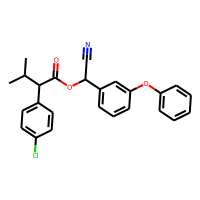
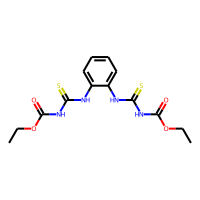

In [19]:
PandasTools.AddMoleculeColumnToFrame(smiles_df,smilesCol="Smiles")
PandasTools.RenderImagesInAllDataFrames(True)
smiles_df.head(2)

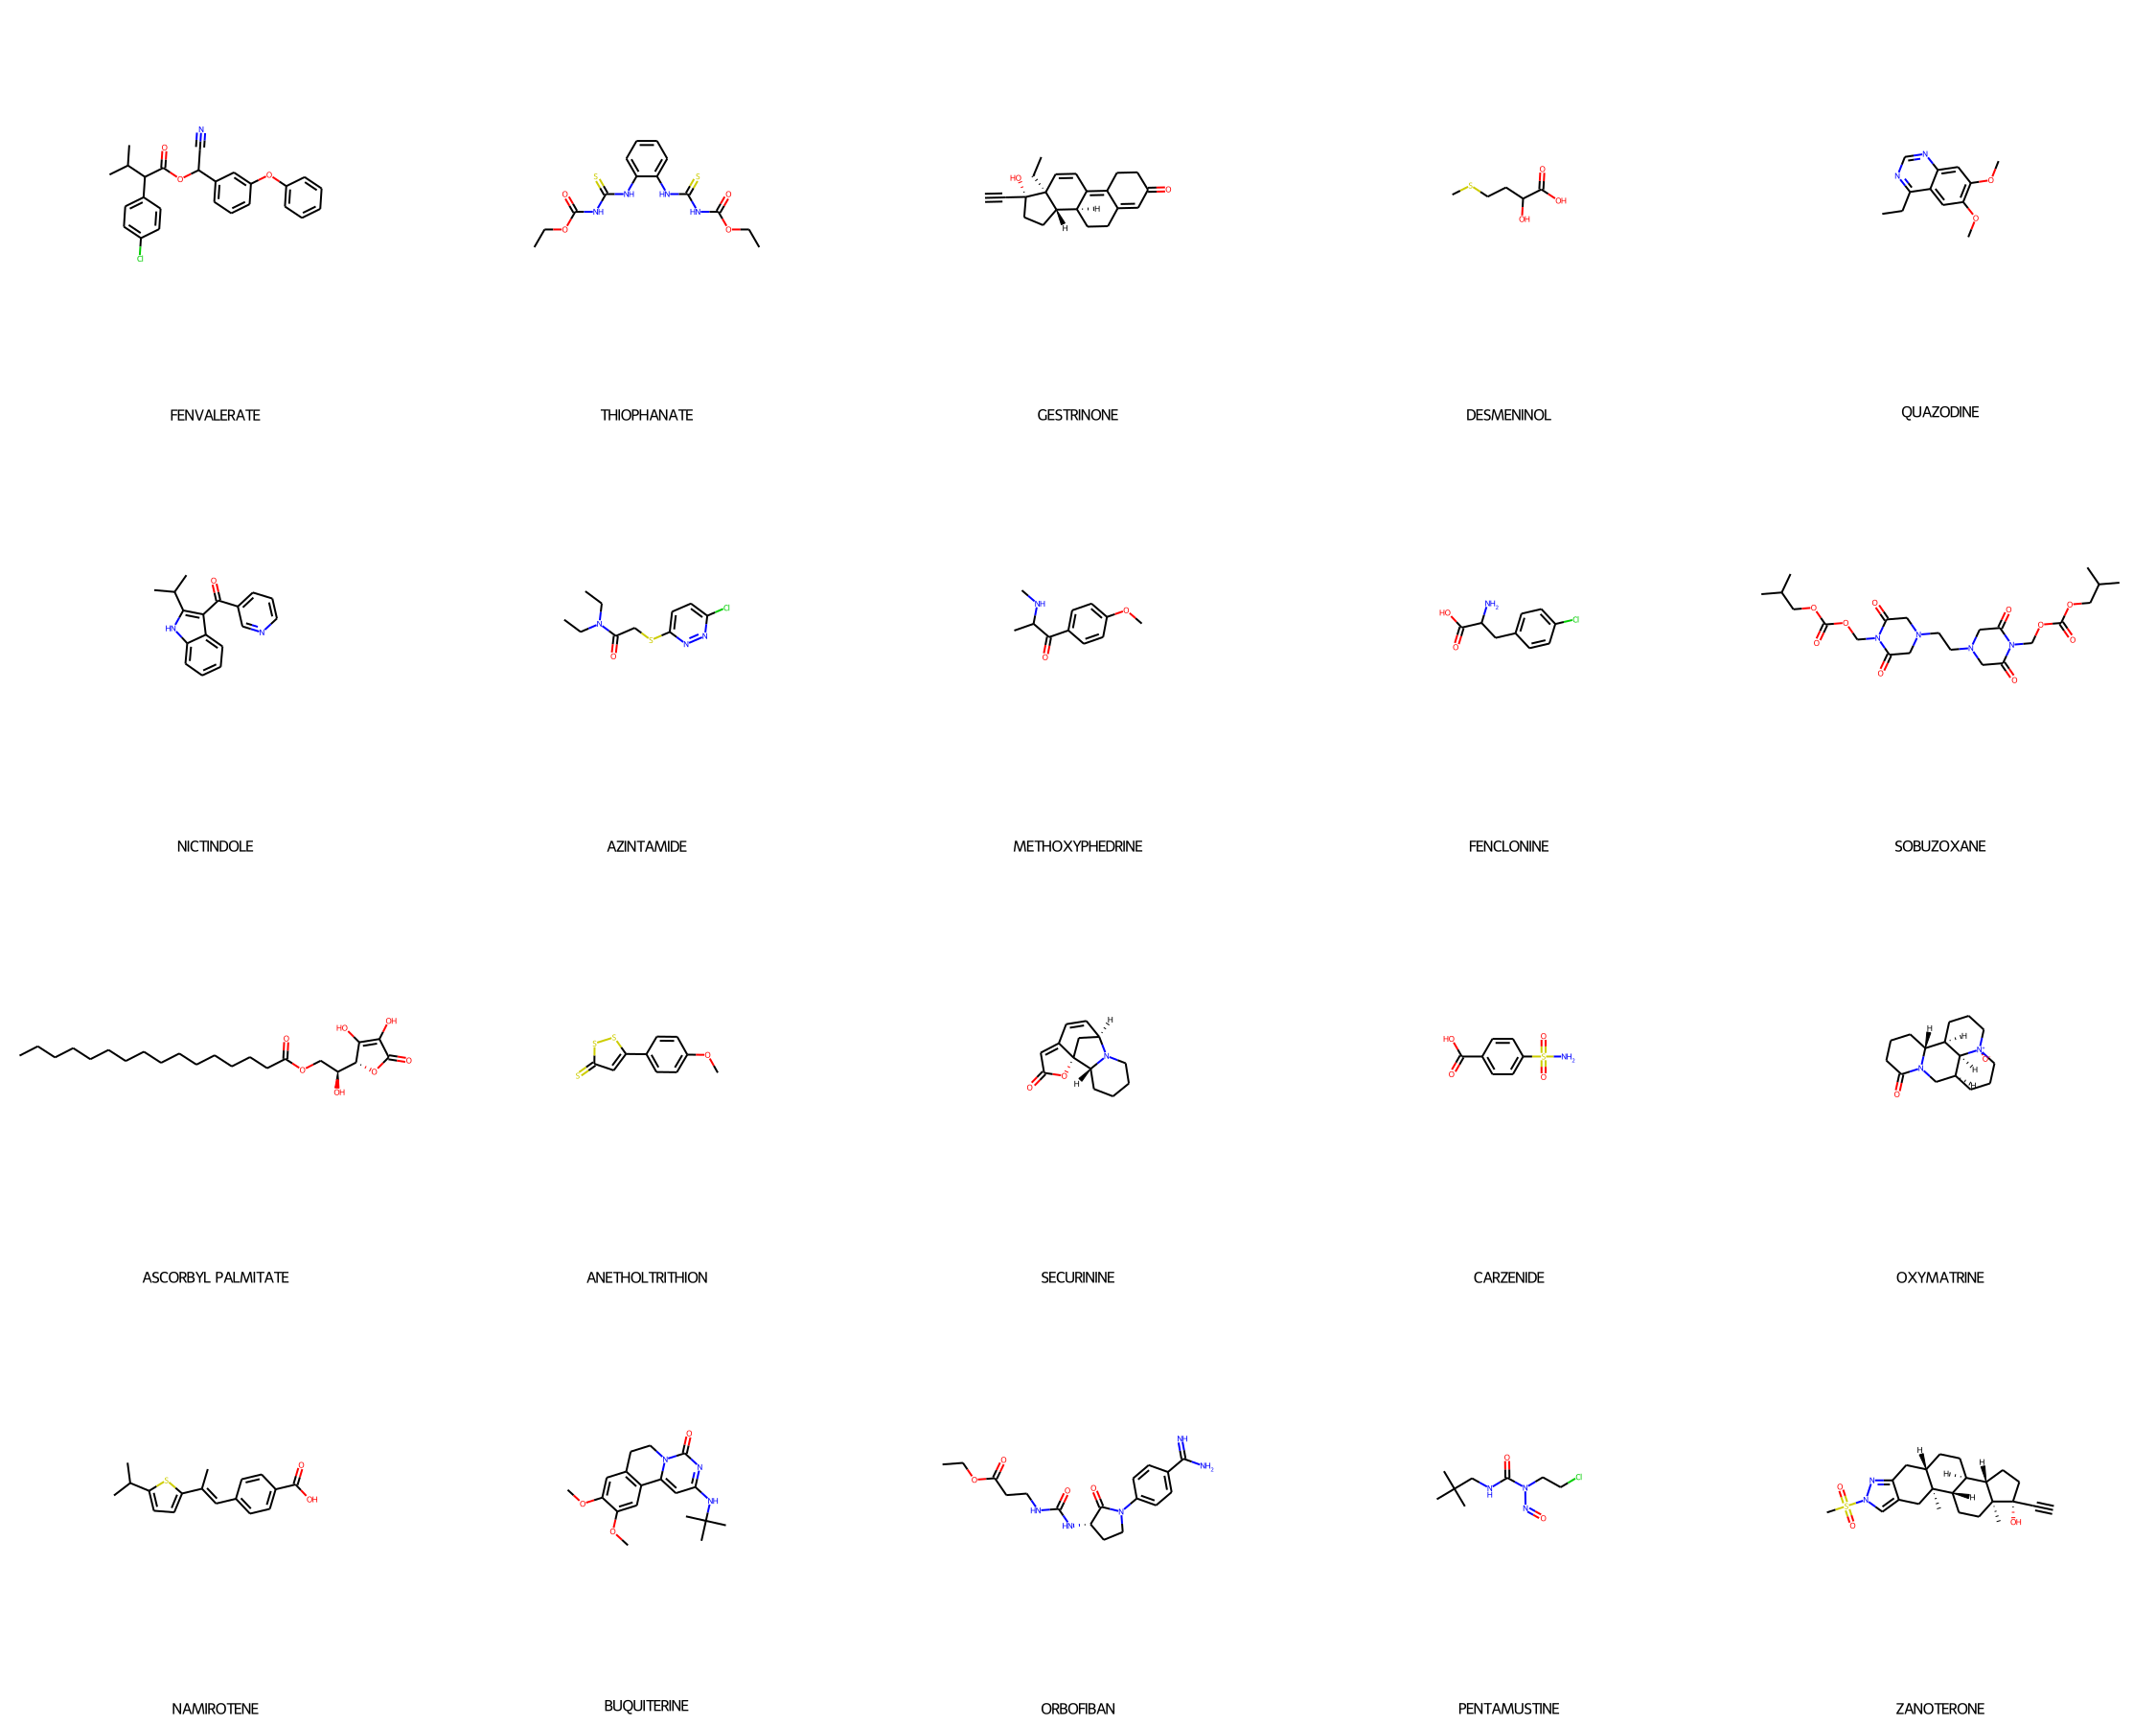

In [20]:
# visualize all molecules
Draw.MolsToGridImage(
    smiles_df["ROMol"].to_list(),
    molsPerRow=5,
    subImgSize=(450,450),
    legends=smiles_df["Name"].to_list(),
)

,Name,Smiles,ROMol,maccs,morgan
0,FENVALERATE,CC(C)C(C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1)c1ccc(C...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,THIOPHANATE,CCOC(=O)NC(=S)Nc1ccccc1NC(=S)NC(=O)OCC,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

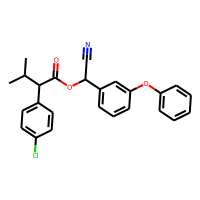
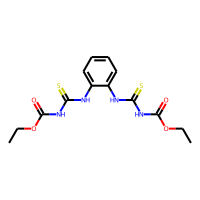

In [21]:
# cal fingerprint
# MACCS
smiles_df["maccs"] = smiles_df.ROMol.apply(MACCSkeys.GenMACCSKeys)
# Morgan
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
smiles_df["morgan"] = smiles_df.ROMol.apply(fpg.GetFingerprint)
smiles_df.head(2)

In [22]:
# cal similarity maccs
mol1_maccs = smiles_df.loc[0,"maccs"] 
mol2_maccs = smiles_df.loc[1,"maccs"] 
DataStructs.TanimotoSimilarity(mol1_maccs,mol2_maccs)

0.23214285714285715

In [23]:
# cal similarity maccs
mol1_morgan = smiles_df.loc[0,"morgan"] 
mol2_morgan = smiles_df.loc[1,"morgan"] 
DataStructs.TanimotoSimilarity(mol1_morgan,mol2_morgan)

0.16666666666666666

In [24]:
# similarity matrix

matrix_size = smiles_df.shape[0]
tanimoto_matrix = np.zeros((matrix_size,matrix_size))
for i in range(matrix_size):
    for j in range(i+1,matrix_size):
        mol_fp_i = smiles_df["morgan"].values[i] 
        mol_fp_j = smiles_df["morgan"].values[j] 
        tanimoto_similarity = DataStructs.TanimotoSimilarity(mol_fp_i,mol_fp_j)
        tanimoto_matrix[i,j] = tanimoto_similarity
        tanimoto_matrix[j,i] = tanimoto_similarity 

In [25]:
tanimoto_matrix

array([[0.        , 0.16666667, 0.06593407, 0.09836066, 0.07142857,
        0.14864865, 0.12676056, 0.17460317, 0.24137931, 0.12676056,
        0.11538462, 0.12307692, 0.03658537, 0.13333333, 0.025     ,
        0.13888889, 0.07142857, 0.11111111, 0.08571429, 0.07291667],
       [0.16666667, 0.        , 0.09589041, 0.11111111, 0.11538462,
        0.15254237, 0.21153846, 0.1875    , 0.14583333, 0.14545455,
        0.18644068, 0.12      , 0.04615385, 0.13333333, 0.03174603,
        0.12068966, 0.08955224, 0.20289855, 0.11320755, 0.075     ],
       [0.06593407, 0.09589041, 0.        , 0.06060606, 0.09859155,
        0.07317073, 0.10666667, 0.08450704, 0.07142857, 0.09210526,
        0.11111111, 0.05555556, 0.12820513, 0.05970149, 0.1038961 ,
        0.0625    , 0.13414634, 0.13186813, 0.06756757, 0.24705882],
       [0.09836066, 0.11111111, 0.06060606, 0.        , 0.06666667,
        0.09433962, 0.12765957, 0.11904762, 0.18421053, 0.12765957,
        0.13207547, 0.02222222, 0.01754386, 0

In [26]:
# tanimoto_matrix_mat = GetTanimotoSimMat(smiles_df["morgan"].values)

In [27]:
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.figure(figsize=(18,18))
ax = sns.heatmap(tanimoto_matrix, annot=True, cmap='viridis', xticklabels=smiles_df["Name"].values, yticklabels=smiles_df["Name"].values)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Similarity Matrix of Molecules')
# plt.xlabel('Molecule')
# plt.ylabel('Molecule')
plt.show()

In [ ]:
# distance = 1- similarity
def tanimoto_distance_matrix(fp_list):
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkAllBitSimilarity(fp_list[i],fp_list[:i])
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

In [ ]:
# cluster function
from rdkit.ML.Cluster import Butina
def cluster_fp(fp_list,cutoff=0.3):
    distance_matrix = tanimoto_distance_matrix(fp_list)
    # print(distance_matrix)
    clusters = Butina.ClusterData(distance_matrix,len(fp_list),cutoff)
    return clusters

In [ ]:
cluster_fp(smiles_df["morgan"].values,cutoff=0.3)

[0.02685546875, 0.04150390625, 0.0322265625, 0.02685546875, 0.01953125, 0.0302734375, 0.03173828125, 0.0224609375, 0.03125, 0.0205078125, 0.03076171875, 0.0244140625, 0.037109375, 0.0234375, 0.02734375, 0.0302734375, 0.02001953125, 0.03271484375, 0.02001953125, 0.02392578125, 0.02685546875, 0.025390625, 0.01904296875, 0.03173828125, 0.01806640625, 0.02099609375, 0.02197265625, 0.0224609375, 0.021484375, 0.02001953125, 0.03173828125, 0.01513671875, 0.02294921875, 0.02392578125, 0.01953125, 0.0185546875, 0.0302734375, 0.02294921875, 0.03369140625, 0.02001953125, 0.02490234375, 0.02783203125, 0.0263671875, 0.021484375, 0.0224609375, 0.03369140625, 0.0234375, 0.03515625, 0.0224609375, 0.0283203125, 0.03125, 0.02880859375, 0.02587890625, 0.02587890625, 0.02490234375, 0.02783203125, 0.021484375, 0.033203125, 0.021484375, 0.01953125, 0.02734375, 0.02490234375, 0.01513671875, 0.02197265625, 0.02587890625, 0.029296875, 0.03857421875, 0.0302734375, 0.033203125, 0.02734375, 0.0302734375, 0.034179

((19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18),)